In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib

## 1. Define S(Qx, Qy) function

In [2]:
def f_ellipse_IQ(Qx, Qy, size, aspect, pl, az, background=0.0, contrast=1.0, flattened=False):
    """
    2D scattering from a uniformly oriented ellipsoid, with:
    - Beam along z-axis
    - pl: angle from +y axis
    - az: angle in xz-plane from +x direction
    
    Parameters:
    - Qx, Qy: 2D arrays of scattering vector components (detector plane)
    - size: equatorial radius
    - aspect: polar / equatorial aspect ratio
    - pl: elevation from +y axis (radians)
    - az: azimuthal angle in xz-plane, az=0 is +x (radians)
    - background: flat background level
    - contrast: scattering length density contrast
    
    Returns:
    - I(q): 2D array of scattering intensity
    """
    Re = size
    Rp = size * aspect

    q = np.sqrt(Qx**2 + Qy**2)
    q_safe = np.where(q == 0, 1e-10, q)  # avoid divide-by-zero

    # Unit vector of q in detector plane (z = 0)
    q_hat = np.stack([Qx / q_safe, Qy / q_safe, np.zeros_like(Qx)], axis=-1)

    # Ellipsoid axis unit vector from (pl, az)
    u = np.array([
        np.sin(pl) * np.cos(az),  # x
        np.cos(pl),               # y
        np.sin(pl) * np.sin(az)   # z
    ])

    # Compute angle between q and ellipsoid axis
    print(q_hat.shape, u.shape)
    ax_index = 2-flattened
    cos_alpha = np.clip(np.tensordot(q_hat, u, axes=([ax_index], [0])), -1.0, 1.0)
    alpha = np.arccos(cos_alpha)

    # Effective radius
    r = np.sqrt(Re**2 * np.sin(alpha)**2 + Rp**2 * np.cos(alpha)**2)

    # Form factor amplitude
    V = (4/3) * np.pi * Re**2 * Rp
    qr = q * r
    qr_safe = np.where(qr == 0, 1e-10, qr)

    F_q = contrast * (3 * (np.sin(qr_safe) - qr_safe * np.cos(qr_safe)) / qr_safe**3)

    # Scattering intensity (unit-normalized)
    I_q = F_q**2 + background
    return I_q



(128, 128, 3) (3,)


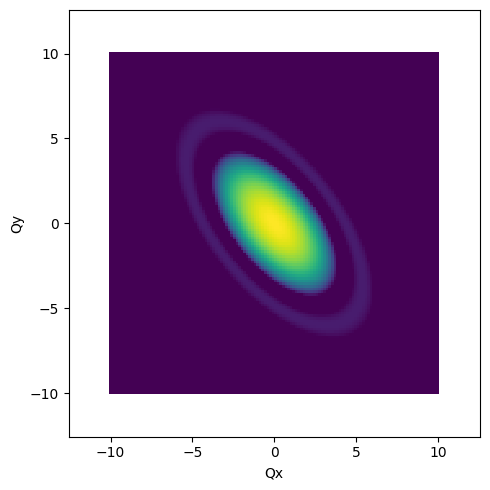

In [50]:
q_list_x = np.linspace(-10, 10, 128)
q_list_y = np.linspace(-10, 10, 128)
qx, qy = np.meshgrid(q_list_x, q_list_y)
qx_flat = qx.flatten()
qy_flat = qy.flatten()

# Parameters
size = 0.8  # equatorial radius (e.g., Å)
aspect = 2.0  # prolate ellipsoid
pl = np.radians(50)  # polar angle
az = np.radians(0)  # azimuthal angle
background = 0.001  # background level

# Compute intensity
p_2D = f_ellipse_IQ(qx, qy, size, aspect, pl, az, background=background)
# p_2D1 = f_ellipse_IQ(qx, qy, size, aspect, pl, az, background=background)
# p_2D2 = f_ellipse_IQ(qx, qy, size, aspect, pl+np.pi/2, az, background=background)
# p_2D = (p_2D1 + p_2D2)/2

# Plot
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log10(p_2D), cmap='viridis', vmax=0, vmin=-2.25)
ax.set_xlabel('Qx')
ax.set_ylabel('Qy')

ax.set_xlim([-4*np.pi, 4*np.pi])
ax.set_ylim([-4*np.pi, 4*np.pi])  # Set limits for the axes

plt.tight_layout()

## 2. Produce detector count

In [51]:
def f_I_q(n_sample, p_qxy, seed =19810, qx_list = q_list_x, qy_list = q_list_y):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel
    bin_edges_x = np.append(qx_list - (qx_list[1] - qx_list[0]) / 2, qx_list[-1] + (qx_list[1] - qx_list[0]) / 2)
    bin_edges_y = np.append(qy_list - (qy_list[1] - qy_list[0]) / 2, qy_list[-1] + (qy_list[1] - qy_list[0]) / 2)
    qx, qy = np.meshgrid(q_list_x, q_list_y)

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid
    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges_x, bin_edges_y])
    
    # evaluate the std of sampled points in each grid
    delta_I_q_grid = np.sqrt(p_qxy/np.sum(p_qxy) * n_sample)

    return I_q_grid.T, delta_I_q_grid

/tmp/ipykernel_728927/1822599489.py:40: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_sample/n_sample*10000), cmap='viridis', vmax=3, vmin=-3)


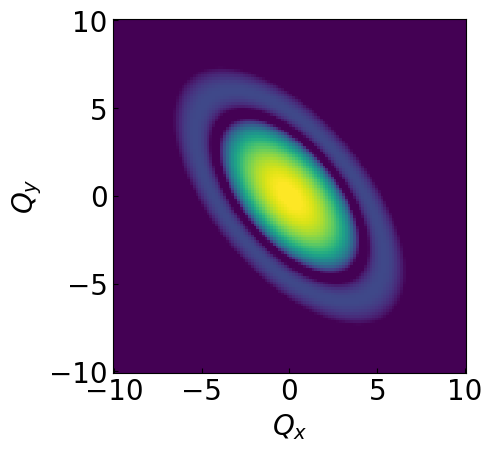

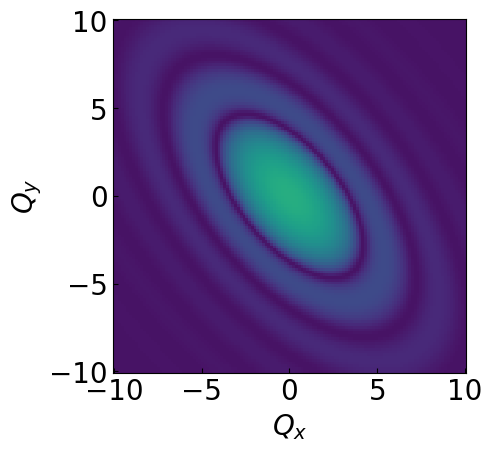

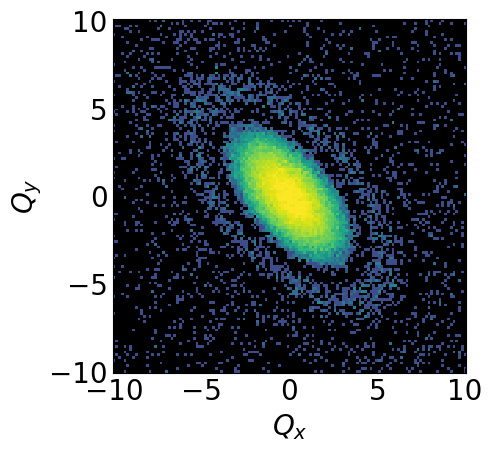

In [52]:
## random sampling
n_sample = 50000

I_q_GT = p_2D/np.sum(p_2D) * n_sample
I_q_sample, delta_I_q_sample = f_I_q(n_sample, p_2D, qx_list=q_list_x, qy_list=q_list_y) ## count per pixel

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_GT/n_sample*10000), cmap='viridis', vmax=3, vmin=-3)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_facecolor('black')
ax.set_aspect(1)
plt.tight_layout()

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(delta_I_q_sample/n_sample*10000), cmap='viridis', vmax=3, vmin=-3)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_facecolor('black')
ax.set_aspect(1)
plt.tight_layout()

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_sample/n_sample*10000), cmap='viridis', vmax=3, vmin=-3)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_facecolor('black')
ax.set_aspect(1)
plt.tight_layout()

## 3. Polar transformation of coordinates

In [53]:
qx_flat = qx.flatten()
qy_flat = qy.flatten()
I_q_GT_flat = I_q_GT.flatten()
I_q_sample_flat = I_q_sample.flatten()

theta_flat = np.arctan2(qy_flat, qx_flat)
q_flat = np.sqrt(qx_flat**2 + qy_flat**2)

/tmp/ipykernel_728927/1474417065.py:16: RuntimeWarning: divide by zero encountered in log
  ax.scatter(theta_flat, q_flat, c=np.log(I_q_sample_flat/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)


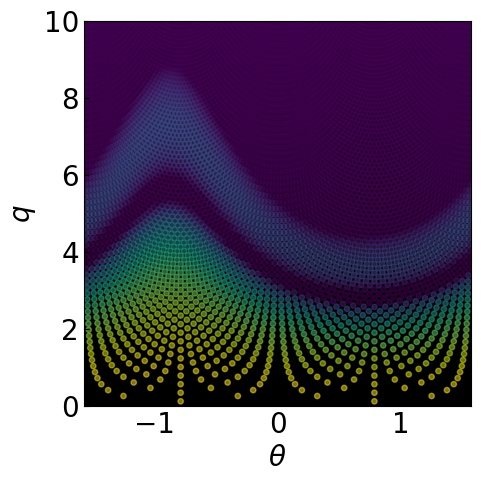

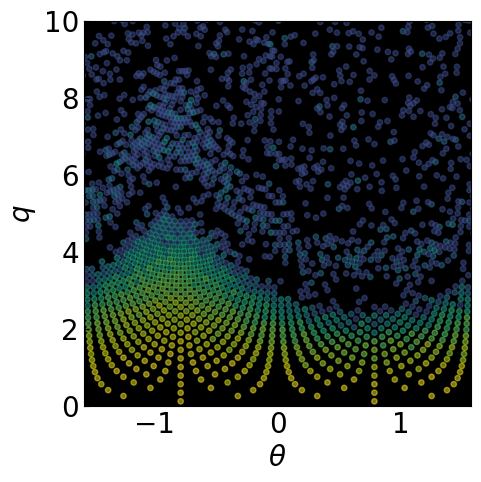

In [54]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(theta_flat, q_flat, c=np.log(I_q_GT_flat/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
# ax.set_yscale('log')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_ylim([0, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set_facecolor('black')

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(theta_flat, q_flat, c=np.log(I_q_sample_flat/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
# ax.set_yscale('log')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_ylim([0, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set_facecolor('black')

## 4. Test the expansion

In [55]:
# def f_C(theta, n):
#     C_0 = np.ones((len(theta), 1))
#     C_cos = np.cos(np.outer(theta, n[1:]))
#     C_sin = np.sin(np.outer(theta, n[1:]))
#     return np.concatenate([C_0, C_cos, C_sin], axis=1)

def f_C(theta, n, theta_0=0):
    theta_shift = theta - theta_0
    C_0 = np.ones((len(theta_shift), 1))
    C_cos = np.cos(np.outer(theta_shift, n[1:]))
    return np.concatenate([C_0, C_cos], axis=1)

def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

(120, 5, 3) (3,)
-50.68294480397029
(120, 30, 3) (3,)


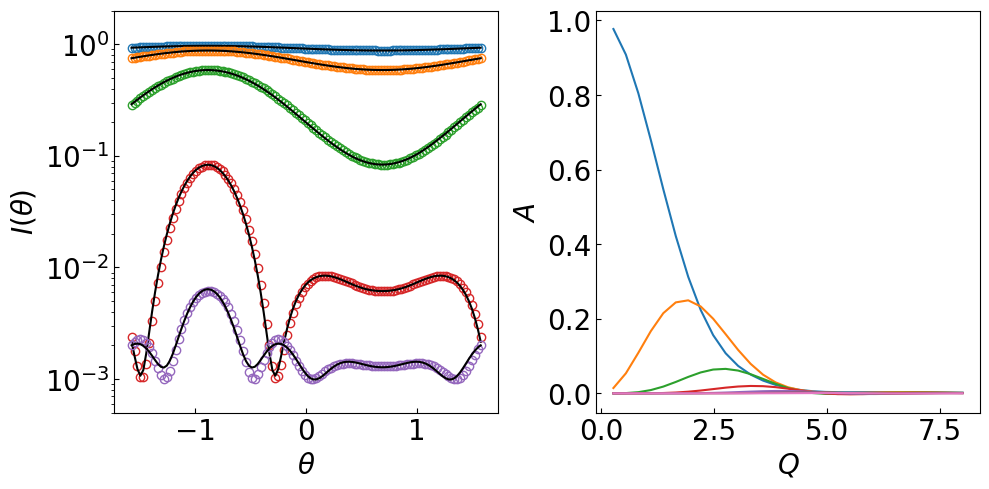

In [56]:
q_polar = np.array([0.5, 1, 2, 4, 8])
# q_polar = np.linspace(0, 8, 5)
theta_polar = np.linspace(-np.pi/2, np.pi/2, 120)
q_polar_grid, theta_polar_grid = np.meshgrid(q_polar, theta_polar)
qx_polar = q_polar_grid * np.cos(theta_polar_grid)
qy_polar = q_polar_grid * np.sin(theta_polar_grid)
qx_polar_flat = qx_polar.flatten()
qy_polar_flat = qy_polar.flatten()

I_q_GT_polar = f_ellipse_IQ(qx_polar, qy_polar, size, aspect, pl, az, background=background)
I_q_GT_polar_flat = I_q_GT_polar.flatten()

# determine the alignment of spectrum according to I, theta
pl_eigen = f_pl_obs(qx_polar_flat, qy_polar_flat, I_q_GT_polar_flat)
print(pl_eigen*180/np.pi)

N_harmonics = 7
n_list = np.arange(N_harmonics)*2

C_arr = f_C(theta_polar, n_list, theta_0=pl_eigen)

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
for i_q in range(len(q_polar)):
    I_i = I_q_GT_polar[:, i_q]
    ax1.plot(theta_polar, I_i, 'o', fillstyle='none', color = color_list[i_q])
    # I = AC
    # find best A
    A = np.linalg.lstsq(C_arr, I_i, rcond=None)[0]
    I_i_fit = np.dot(C_arr, A)
    ax1.plot(theta_polar, I_i_fit, '-', fillstyle='none', color = 'k')
    
ax1.set_yscale('log')
ax1.set_ylim([0.0005, 2])
ax1.tick_params(direction='in', labelsize=20)
ax1.set_xlabel(r'$\theta$', fontsize=20)
ax1.set_ylabel(r'$I(\theta)$', fontsize=20)

q_polar_fine = np.linspace(0, 8, 30)
q_polar_grid_fine, theta_polar_grid_fine = np.meshgrid(q_polar_fine, theta_polar)
qx_polar_fine = q_polar_grid_fine * np.cos(theta_polar_grid_fine)
qy_polar_fine = q_polar_grid_fine * np.sin(theta_polar_grid_fine)
qx_polar_fine_flat = qx_polar_fine.flatten()
qy_polar_fine_flat = qy_polar_fine.flatten()

I_q_GT_polar_fine = f_ellipse_IQ(qx_polar_fine, qy_polar_fine, size, aspect, pl, az, background=background)

A_fine_list = []
for i_q in range(len(q_polar_fine)):
    I_i = I_q_GT_polar_fine[:, i_q]
    # I = AC
    # find best A
    A = np.linalg.lstsq(C_arr, I_i, rcond=None)[0]
    A_fine_list.append(A)
    
A_fine = np.array(A_fine_list)
ax2.plot(q_polar_fine[1:], A_fine[1:, 0:11], '-', fillstyle='none')

ax2.tick_params(direction='in', labelsize=20)
ax2.set_xlabel(r'$Q$', fontsize=20)
ax2.set_ylabel(r'$A$', fontsize=20)

plt.tight_layout()

## 5. Inference

In [106]:
# Tool functions for Bayesian inference
def rbf_kernel(Q, lambda_):
    """
    Compute the spatial correlation kernel k_{i j}.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (1D array).
        lambda_ (float): Length scale parameter for the RBF kernel.

    Returns:
        numpy.ndarray: Spatial correlation kernel matrix of shape (len(Q), len(Q)).
    """
    Q_i, Q_j = np.meshgrid(Q, Q, indexing='ij')
    return np.exp(-((Q_i - Q_j) ** 2) / (2 * lambda_ ** 2))

def construct_transformation_matrix(theta, n):
    """
    Compute the transformation matrix C_{a n}.

    Parameters:
        theta (numpy.ndarray): 1D array of azimuthal angles (in radians).
        n (numpy.ndarray): 1D array of harmonic orders.

    Returns:
        numpy.ndarray: Complex-valued transformation matrix of shape (len(n), len(theta)).
    """
    C = np.exp(1j * theta[None,:] * n[:,None])
    return C

# Bayesian inference function for off-grid scattering data
def bayesian_inference(I_obs, delta_I_obs, Q_obs, theta_obs, Q_eval, theta_eval, list_n, mu_, lambda_, direct_reconstruction=False):
    # L, M, N = len(Q_eval), len(Q_obs), len(list_n)*2 - 1
    L, M, N = len(Q_eval), len(Q_obs), len(list_n) # using predetermined alignment angle
    print(f"L: {L}, M: {M}, N: {N}")

    # Step 1: Spatial interpolation kernel (W_ai), not normalized
    spatial_kernel = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))

    # Step 2: Angular basis (M x N)
    # determine alignment angle
    pl_eigen = f_pl_obs(Q_obs*np.cos(theta_obs), Q_obs*np.sin(theta_obs), I_obs)
    orientational_kernel = f_C(theta_obs, list_n, theta_0=pl_eigen)

    # Step 3: Design matrix G (M x LN)
    G = (spatial_kernel[:, :, None] * orientational_kernel[:, None, :]).reshape(M, L * N)

    # Step 4: Prior covariance matrix (LN x LN)
    Q_dist = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    spatial_prior_kernel = np.exp(-Q_dist / (2 * lambda_ ** 2))
    # K_prior = np.kron(np.eye(N), spatial_prior_kernel)
    K_prior = np.kron(np.diag((np.arange(N)+1)**2), spatial_prior_kernel) # supprress the higher order term

    # Step 5: Noise covariance (M x M)
    Sigma = np.diag(delta_I_obs ** 2)

    # --------------------------
    # PRIOR MEAN COMPUTATION
    # --------------------------
    # Compute prior mean mu_A of shape (L, N)
    W_ai = spatial_kernel
    W_ai /= W_ai.sum(axis=0)  # normalize
    # mu_0 = (W_ai.T @ I_obs) / (W_ai.sum(axis=0))  # (L,)
    # mu_A = np.zeros((L, N))
    # mu_A[:, 0] = mu_0  # Set isotropic component only
    
    mu_A = np.einsum('ai,an,a->in', W_ai, orientational_kernel, I_obs) # assign prior mean to each harmonic

    # --------------------------
    # POSTERIOR COMPUTATION
    # --------------------------
    mu_A_flat = mu_A.flatten()  # shape (L*N,)
    residual = I_obs - G @ mu_A_flat  # centered data
    GK = G @ K_prior
    K_tilde = GK @ G.T + Sigma
    cho_K_tilde = cho_factor(K_tilde + 1e-8 * np.eye(M))

    A_posterior_flat = mu_A_flat + K_prior @ G.T @ cho_solve(cho_K_tilde, residual)
    A_GPR = A_posterior_flat.reshape(L, N)

    # Posterior covariance (L, N, L, N)
    K_GPR_flat = K_prior - K_prior @ G.T @ cho_solve(cho_K_tilde, G @ K_prior)
    K_GPR = K_GPR_flat.reshape(L, N, L, N)

    # --------------------------
    # RECONSTRUCTION
    # --------------------------
    spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
    orientational_kernel_eval = f_C(theta_eval, list_n, theta_0=pl_eigen)
    S_reconstructed = np.einsum('ij,in,kn->kj', spatial_kernel_eval, A_GPR, orientational_kernel_eval)
    
    if direct_reconstruction:
        S_reconstructed = np.einsum('in,kn->ki', A_GPR, orientational_kernel_eval)

    return A_GPR, K_GPR, S_reconstructed


In [107]:
Q_obs = np.sqrt(qx_flat**2 + qy_flat**2)
theta_obs = np.arctan2(qy_flat, qx_flat)

I_obs = I_q_sample_flat
delta_I_obs = np.sqrt(I_q_GT_flat)

# probabilities = 1 / Q_obs**0
# probabilities /= probabilities.sum()  # Normalize to make it a probability distribution
# selected_indices = np.random.choice(len(Q_obs), size=12000, p=probabilities, replace=False)

# Q_obs = Q_obs[selected_indices]
# theta_obs = theta_obs[selected_indices]
# I_obs = I_obs[selected_indices]
# delta_I_obs = delta_I_obs[selected_indices]

Q_lb = 0
Q_ub = 10
index_radial = (Q_obs < Q_ub) & (Q_obs > Q_lb) 
theta_obs = theta_obs[index_radial]
I_obs = I_obs[index_radial]
delta_I_obs = delta_I_obs[index_radial]
Q_obs = Q_obs[index_radial]

Q_eval = np.linspace(Q_lb, Q_ub, 200)
theta_eval = np.linspace(-np.pi, np.pi, 200)
Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)

lambda_ = 0.05
mu_ = 0.05

N_harmonics = 7
list_n = np.arange(N_harmonics)*2

A_GPR, K_GPR, I_eval = bayesian_inference(
    I_obs, delta_I_obs, Q_obs, theta_obs, Q_eval, theta_eval, list_n, mu_, lambda_,
    direct_reconstruction=False
)

L: 200, M: 12644, N: 7


/tmp/ipykernel_728927/627701800.py:4: RuntimeWarning: invalid value encountered in log
  ax.scatter(theta_eval_grid, Q_eval_grid, c=np.log((I_eval)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
/tmp/ipykernel_728927/627701800.py:16: RuntimeWarning: divide by zero encountered in log
  ax.scatter(theta_obs, Q_obs, c=np.log((I_obs)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
/tmp/ipykernel_728927/627701800.py:28: RuntimeWarning: invalid value encountered in log
  ax.scatter(Q_eval_grid*np.cos(theta_eval_grid), Q_eval_grid*np.sin(theta_eval_grid), c=np.log((I_eval)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
/tmp/ipykernel_728927/627701800.py:44: RuntimeWarning: divide by zero encountered in log
  ax.scatter(Q_obs*np.cos(theta_obs), Q_obs*np.sin(theta_obs), c=np.log((I_obs)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)


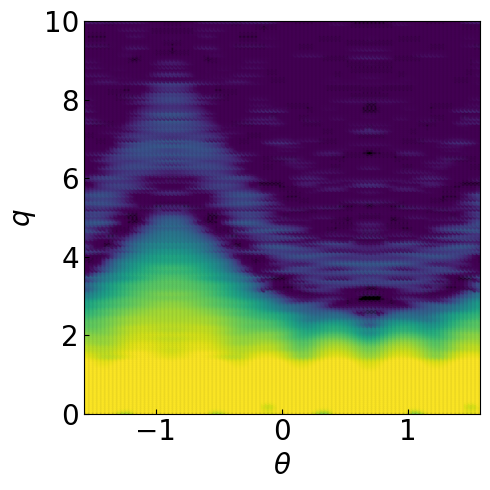

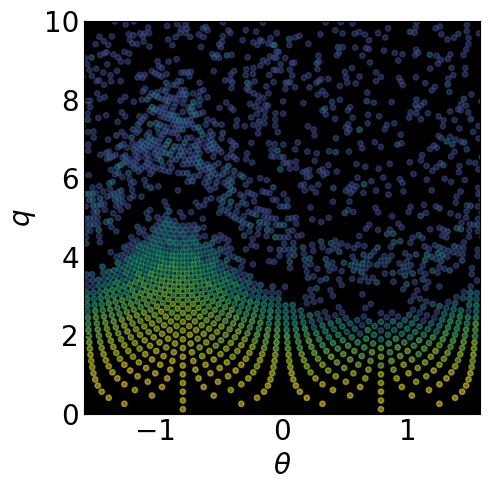

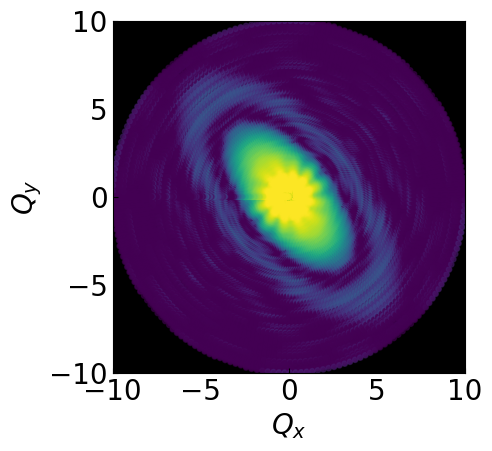

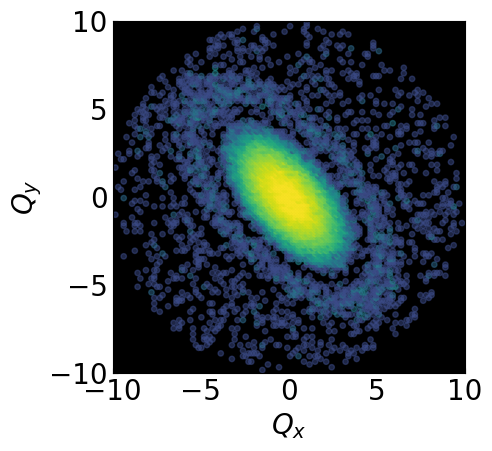

In [108]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(theta_eval_grid, Q_eval_grid, c=np.log((I_eval)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_ylim([0, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(theta_obs, Q_obs, c=np.log((I_obs)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_ylim([0, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(Q_eval_grid*np.cos(theta_eval_grid), Q_eval_grid*np.sin(theta_eval_grid), c=np.log((I_eval)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_facecolor('black')
ax.set_aspect(1)
plt.tight_layout()

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.scatter(Q_obs*np.cos(theta_obs), Q_obs*np.sin(theta_obs), c=np.log((I_obs)/n_sample*10000), s=15, alpha=0.5, label='GT', vmax=3, vmin=-3)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_facecolor('black')
ax.set_aspect(1)
plt.tight_layout()

(120, 200, 3) (3,)


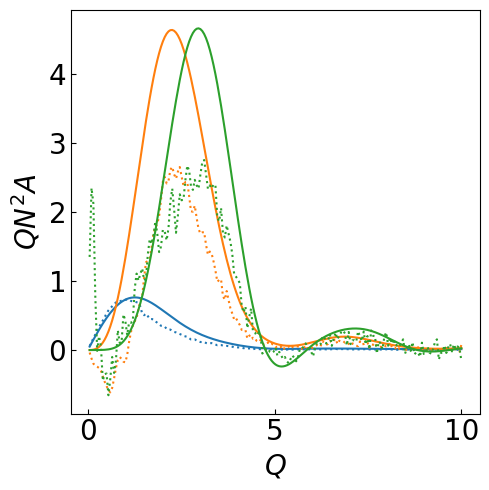

In [109]:
# compare the extracted coefficients
list_n = np.arange(N_harmonics)*2
C_arr = f_C(theta_polar, list_n, theta_0=pl_eigen)

fig = plt.figure(figsize=(5,5))
ax2 = plt.subplot(1, 1, 1)

q_polar_fine = Q_eval
theta_polar_fine = theta_eval
q_polar_grid_fine, theta_polar_grid_fine = np.meshgrid(q_polar_fine, theta_polar)
qx_polar_fine = q_polar_grid_fine * np.cos(theta_polar_grid_fine)
qy_polar_fine = q_polar_grid_fine * np.sin(theta_polar_grid_fine)
qx_polar_fine_flat = qx_polar_fine.flatten()
qy_polar_fine_flat = qy_polar_fine.flatten()

I_q_GT_polar_fine = f_ellipse_IQ(qx_polar_fine, qy_polar_fine, size, aspect, pl, az, background=background)

# Ground truth of the coefficients
A_fine_list = []
for i_q in range(len(q_polar_fine)):
    I_i = I_q_GT_polar_fine[:, i_q]
    # I = AC
    # find best A
    A = np.linalg.lstsq(C_arr, I_i, rcond=None)[0]
    A_fine_list.append(A)
A_fine = np.array(A_fine_list)

# GPR reconstructed coefficients
spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
A_reconstructed = np.einsum('ij,in->jn', spatial_kernel_eval, A_GPR)

for i_basis in range(3):
    order = 2*i_basis
    ax2.plot(q_polar_fine[1:], A_fine[1:, i_basis]*(order+1)**2*q_polar_fine[1:], '-', fillstyle='none', color = color_list[i_basis])
    ax2.plot(q_polar_fine[1:], A_reconstructed[1:, i_basis]*(order+1)**2*q_polar_fine[1:]/len(Q_eval), ':', fillstyle='none', color = color_list[i_basis])

ax2.tick_params(direction='in', labelsize=20)
ax2.set_xlabel(r'$Q$', fontsize=20)
ax2.set_ylabel(r'$QN^2A$', fontsize=20)
# ax2.set_ylim([-1, 1])

plt.tight_layout()

## 6. Merged dataset

In [ ]:
q_list_1 = np.linspace(-10, 10, 128)
q_list_2 = np.linspace(-1, 1, 128)
qx_1, qy_1 = np.meshgrid(q_list_1, q_list_1)
qx_2, qy_2 = np.meshgrid(q_list_2, q_list_2)
qx_1_flat = qx_1.flatten()
qy_1_flat = qy_2.flatten()
qx_2_flat = qx_2.flatten()
qy_2_flat = qy_2.flatten()

p_2D_1 = f_ellipse_IQ(qx_1, qy_1, size, aspect, pl, az, background=background)
p_2D_2 = f_ellipse_IQ(qx_2, qy_2, size, aspect, pl, az, background=background)

I_q_sample_1, delta_I_q_sample_1 = f_I_q(n_sample, p_2D_1, qx_list=q_list_1, qy_list=q_list_1)
I_q_sample_2, delta_I_q_sample_2 = f_I_q(n_sample, p_2D_2, qx_list=q_list_2, qy_list=q_list_2)

